## Подготовка dataset-а

Все алгоритмы глубинного обучения не могут работать без данных. Поэтому чтобы обучить нашу модель писать как Достоевский, нам нужны данные текста Достоевского. 

#### Пример

**Natural Language Toolkit (nltk)** — это очень удобная библиотека для работы с текстом, предоставляющая множество полезных функций, которые мы будем использовать в нашем проекте. Если вы хотите лучше ознакомиться с возможностями nltk, я рекомендую просмотреть этот плейлист на YouTube (на английском): NLTK Playlist.

Кроме того, мы будем использовать библиотеку **Regular Expression (RegEx, re)**. Эта библиотека позволяет работать с регулярными выражениями, которые необходимы для поиска и обработки текста. RegEx поможет нам эффективно обрабатывать текстовые данные и извлекать нужную информацию.

##### Установка через pip

In [1]:
!pip3 install nltk regex

Defaulting to user installation because normal site-packages is not writeable


##### Загрузка файла книги и чтение через команду read()

Обратите внимание, что по умолчанию в Linux используется кодировка UTF-8. Хорошая новость: UTF-8 поддерживает кириллицу, так что для работы с русским текстом обычно ничего менять не нужно. Но если вы вдруг столкнетесь с файлами в другой кодировке, например, Windows-1251, вам придется их преобразовать, чтобы программа правильно распознала все символы. Файл book.txt был записан именно с этой кодировкой, так что нам нужно будет указать какую именно кодировку мы используем

In [9]:
import os

books = []
for filename in os.listdir('books'):
    if filename.endswith('bednye.txt'):
        with open(f'books/{filename}', 'r') as file:
            books.append(file.read())
data = " ".join(books)

##### Чистка

Когда мы загружаем книгу, иногда можем увидеть в тексте странные символы, такие как \n, \r или \xa0. Эти символы понятны компьютерам и выполняют специальные функции. Например, \n переносит текст на новую строку, \r возвращает курсор в начало строки, а \xa0 представляет собой неразрывный пробел.
Мы не хотим, чтобы наш мини-Достоевский использовал эти символы, поэтому нам нужно избавиться от них. Вот как мы можем это сделать с помощью re. Но стоит подумать о символе \n, это по факту новая строка, скорее всего нашей модели стоит научиться его вставлять для лучшего форматирования текста

In [6]:
# Отобразим первые 1000 символов из книг
example = data[:1000]
example

'[]\n\nAnnotation\n\n«Я смешной человек. Они меня называют теперь сумасшедшим. Это было бы повышение в чине, если б я всё еще не оставался для них таким же смешным, как и прежде. Но теперь уж я не сержусь, теперь они все мне милы, и даже когда они смеются надо мной – и тогда чем-то даже особенно милы. Я бы сам смеялся с ними,\xa0– не то что над собой, а их любя, если б мне не было так грустно, на них глядя. Грустно потому, что они не знают истины, а я знаю истину. Ох, как тяжело одному знать истину! Но они этого не поймут. Нет, не поймут…»\n\n------------------------------------------------------------------------\n\n-   Федор Михайлович Достоевский\n    -   I\n    -   II\n    -   III\n    -   IV\n    -   V\n-   notes\n    -   1\n    -   2\n    -   3\n\n------------------------------------------------------------------------\n\nФедор Михайлович Достоевский Сон смешного человека ^(Фантастический\\ рассказ) \n\nI \n\nЯ смешной человек. Они меня называют теперь сумасшедшим. Это было бы по

In [11]:
# Теперь очистим 
import re
import html

def clean_text(text):
    """
    Очищает текст, удаляя HTML-экранирование, номера страниц, глав, сноски и спецсимволы.

    Args:
        text (str): Исходный текст для очистки.

    Returns:
        str: Очищенный текст.
    """
    
    # 1. Декодирование HTML-сущностей (например, &amp; -> &)
    # Комментарий: Это должно быть одним из первых шагов.
    text = html.unescape(text)

    advertisement_patterns = [
        r'^\s*Спасибо, что скачали книгу в бесплатной электронной библиотеке.*?Royallib\.ru.*?\n',
        r'^\s*Все книги автора:.*?Royallib\.ru.*?\n',
        r'^\s*Эта же книга в других форматах:.*?Royallib\.ru.*?\n',
        r'^\s*Приятного чтения!\s*\n',
        r'^\s*Royallib Publishing\s*\n', # Возможная дополнительная строка
        r'^\s*http://royallib\.ru.*?\n', # Более общее правило для URL Royallib
        r'^\s*http://royallib\.com.*?\n', # Если домен .com
        # Добавьте другие шаблоны, если найдете рекламу от других источников
    ]
    for pattern in advertisement_patterns:
        text = re.sub(pattern, '', text, flags=re.MULTILINE | re.IGNORECASE)
    
    # 2. Удаление специфических заголовков и разделителей (строки целиком)
    # Комментарий: Удаляем известные заголовки и маркеры перед основной обработкой глав/страниц.
    # Эти шаблоны применяются ко всему тексту с флагом MULTILINE.
    full_line_removals = [
        r'^\s*Annotation\s*$',      # Удаление строки "Annotation"
        r'^\s*notes\s*\d*\s*$',     # Удаление строк типа "notes" или "notes123"
        r'^\s*сноски\s*\d*\s*$',    # Русскоязычный вариант "notes"
        r'^\s*\*\s*\*\s*\*\s*$',    # Удаление разделителей "***"
    ]
    for pattern in full_line_removals:
        text = re.sub(pattern, '', text, flags=re.MULTILINE | re.IGNORECASE)

    # 3. Удаление заголовков глав
    # Комментарий: Ищем строки, начинающиеся с типичных обозначений глав/частей.
    # Обновленный шаблон для "Часть перваяI" и подобных.
    # Также удаляем строки, состоящие только из римских или арабских цифр (часто номера глав/разделов).
    chapter_patterns = [
        # Шаблон для "Глава X", "Part 1", "Часть первая", "Книга Первая", "Часть перваяI"
        r'^\s*(Глава|CHAPTER|Chapter|Part|PART|Часть|КНИГА|BOOK)\s+([IVXLCDM\d]+|[А-Яа-яЁё\w\s]+)([IVXLCDM\d]*)\.?\s*$',
        # Шаблон для строк, содержащих только римские или арабские цифры (номера глав/частей)
        r'^\s*([IVXLCDM]+|[0-9]+)\.?\s*$' 
    ]
    for pattern in chapter_patterns:
        text = re.sub(pattern, '', text, flags=re.MULTILINE | re.IGNORECASE)

    # 4. Удаление номеров страниц (строки, состоящие только из цифр, или цифры по краям)
    # Комментарий: Эвристика для номеров страниц.
    text = re.sub(r'^\s*\d+\s*$', '', text, flags=re.MULTILINE) # Строка только из цифр
    text = re.sub(r'^\s*\d+\s*\n', '', text, flags=re.MULTILINE) # Цифры в начале строки (редко, но возможно)
    text = re.sub(r'\n\s*\d+\s*$', '', text, flags=re.MULTILINE) # Цифры в конце строки (классические номера страниц)
    
    # Удаление inline ссылок на страницы типа "Стр. 23"
    text = re.sub(r'(Стр\.|Page|Стр)\s*\.?\s*\d+', '', text, flags=re.IGNORECASE)

    # 5. Удаление маркеров сносок (внутри текста)
    # Комментарий: Удаляем распространенные маркеры сносок типа [1], (2), *.
    footnote_marker_patterns = [
        r'\[\d+\]',              # [1], [23]
        r'\(\d+\)',              # (1), (23)
        r'\{\d+\}',              # {1}, {23}
        r'\s+\*\s+',             # Одиночная звездочка как маркер сноски (окруженная пробелами)
                                 # Осторожно: может удалить стилистически важные звездочки, если они не сноски.
                                 # Лучше сделать более специфичным, если это проблема.
        r'\(\*\)',               # (*)
        r'(?<!\w)\[\*\](?!\w)'   # [*] как отдельный маркер
    ]
    for pattern in footnote_marker_patterns:
        text = re.sub(pattern, ' ', text) # Заменяем на пробел, чтобы не склеить слова

    # 6. Удаление нежелательных специальных символов
    # Комментарий: Сохраняем кириллицу, латиницу, цифры, основную пунктуацию и пробельные символы (включая \n).
    # \w включает буквы, цифры и '_'.
    text = re.sub(r'[^\w\sа-яА-ЯёЁ.,!?:;"\'«»(\)„“”—\-]', '', text, flags=re.UNICODE)

    # 7. Нормализация пробельных символов (этот шаг выполняется последним)
    # Комментарий: Сначала обрабатываем горизонтальные пробелы на каждой строке,
    # затем удаляем пустые строки и нормализуем переносы строк.

    # Заменяем множественные горизонтальные пробелы (пробел, таб) на один пробел внутри строк
    text = re.sub(r'[ \t\f\v]+', ' ', text)

    # Разделяем на строки, очищаем каждую строку от начальных/конечных пробелов,
    # и собираем обратно только непустые строки.
    lines = text.split('\n')
    processed_lines = []
    for line in lines:
        stripped_line = line.strip() # Удаляем пробелы в начале и конце каждой строки
        if stripped_line: # Добавляем строку, только если она не пустая
            processed_lines.append(stripped_line)
    
    # Соединяем непустые строки одним символом новой строки.
    # Это создаст текст, где каждый "абзац" или значащая строка отделена одним \n.
    text = "\n".join(processed_lines)

    return text

example = clean_text(example)
example

'н рубль ассигнациями был равен 27\xa0коп. серебром.\nТереза да Фальдони \xa0ставшие нарицательными имена героев популярного сентиментального романа Н.-Ж. Леонара «Тереза и Фальдони, или Письма двух любовников, живших в Лионе» .\nСвидание (фр. rendez-vous).\nКабалу стряпал т.\xa0е. возводил напраслину.\nГрафиня-герцогиня (франц. comtesse-duchesse).\n14\xa0класс самый низший класс «Табели о рангах», введенной Петром I.\nЗавоеваниями (фр. conquête)\nЛовелас ставшее нарицательным имя героя2любовника романа С. Ричардсона «Кларисса Гарлоу» (17471748).\nКнижник т.\xa0е. бумажник (устар.).\n«Пчелка» газета «Северная пчела», издававшаяся в Петербурге в 18251864\xa0гг. Ф. В. Булгариным и Н. И. Гречет.\nБлонды (фр. blonde)\xa0 шелковые кружева.\nЛегкая кофточка без рукавов (фр. canezou).\nКрошь, тамбур, кордоне (фр. crochet крючок; tambour abroden пяльцы; cordonnet шнурок, тесьма)\xa0 различные способы вышивки.\nОборкой (фр. falbala).'

In [12]:
example = data[-1000:]
print(example)
print(clean_text(example))

н рубль ассигнациями был равен 27 коп. серебром.

4 

Тереза да Фальдони – ставшие нарицательными имена героев популярного сентиментального романа Н.-Ж. Леонара «Тереза и Фальдони, или Письма двух любовников, живших в Лионе» (1783).

5 

Свидание (фр. rendez-vous).

6 

Кабалу стряпал – т. е. возводил напраслину.

7 

Графиня-герцогиня (франц. comtesse-duchesse).

8 

14 класс – самый низший класс «Табели о рангах», введенной Петром I.

9 

Завоеваниями (фр. conquête)

10 

Ловелас – ставшее нарицательным имя героя2любовника романа С. Ричардсона «Кларисса Гарлоу» (1747–1748).

11 

Книжник – т. е. бумажник (устар.).

12 

«Пчелка» – газета «Северная пчела», издававшаяся в Петербурге в 1825–1864 гг. Ф. В. Булгариным и Н. И. Гречет.

13 

Блонды (фр. blonde) – шелковые кружева.

14 

Легкая кофточка без рукавов (фр. canezou).

15 

Крошь, тамбур, кордоне (фр. crochet – крючок; tambour abroden – пяльцы; cordonnet – шнурок, тесьма) – различные способы вышивки.

16 

Оборкой (фр. falbala).


Пора сделать чистку всей книги

In [5]:
data = clean_text(data)

Отлично, книга очищена от специальных символов, давайте подумаем что еще можно сделать. 

#### Деление книги на слова, предложения

Сейчас объект book содержит в себе строку со всей книгой, мы хотим поделить эту строку на отдельные слова или предложения. Сделать мы это сможем с помощью **nltk**

In [6]:
import nltk
from nltk import word_tokenize
# Скачать нужные данные
nltk.download('punkt')
# Поделить на слова
words = word_tokenize(data)

[nltk_data] Downloading package punkt to /home/fenixkz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
words[:50]

['«',
 'Идиот',
 '»',
 '.',
 'Роман',
 ',',
 'в',
 'котором',
 'творческие',
 'принципы',
 'Достоевского',
 'воплощаются',
 'в',
 'полной',
 'мере',
 ',',
 'а',
 'удивительное',
 'владение',
 'сюжетом',
 'достигает',
 'подлинного',
 'расцвета',
 '.',
 'Яркая',
 'и',
 'почти',
 'болезненно',
 'талантливая',
 'история',
 'несчастного',
 'князя',
 'Мышкина',
 ',',
 'неистового',
 'Парфена',
 'Рогожина',
 'и',
 'отчаявшейся',
 'Настасьи',
 'Филипповны',
 ',',
 'много',
 'раз',
 'экранизированная',
 'и',
 'поставленная',
 'на',
 'сцене',
 ',']

Мы теперь имеем массив со всеми словами в книге (заметьте что пунктуация тут тоже учитывается)

In [8]:
print(f"Сколько всего слова в книгах? {len(words)}")

Сколько всего слова в книгах? 1081903


Ну конечно что все слова повторяются, мы можем избавиться от дупликатов использую set(). Set является чем-то на подобии массива, только он не содержит в себе дупликатов, например

In [9]:
a = [1, 2, 3, 1, 2, 5, 6, 6, 8, 9] # лист с элементами, которые повторяются
set(a) 

{1, 2, 3, 5, 6, 8, 9}

In [10]:
print(f"Сколько разных слов использовано в книге? {len(set(words))}")

Сколько разных слов использовано в книге? 77924


Давайте отсортируем слова

In [11]:
vocabulary = set(words) # Наш словарь
sorted_words = sorted(list(vocabulary))

In [12]:
sorted_words

['!',
 ',',
 '-с',
 '-то',
 '.',
 '..',
 '12,797',
 '1413',
 '1428',
 '16',
 '16831757',
 '17121778',
 '18091842',
 '18131873',
 '18531856',
 '1854',
 '187',
 '19',
 '19-го',
 '2,134',
 '24',
 '30',
 '31',
 '32-го',
 '3236',
 '37,5',
 '4,44',
 '40',
 '67',
 '71',
 '76',
 '8',
 '80',
 '98',
 ':',
 ';',
 '?',
 'A',
 'Adieu',
 'Agent-provocateur',
 'Ah',
 'Alea',
 'Allons',
 'An',
 'Andrejeff',
 'Après',
 'Assez',
 'Au',
 'Augen',
 'Augustin',
 'Avis',
 'Ax',
 'Babette',
 'Badinguet',
 'Bah',
 'Barmherzige',
 'Belge',
 'Bonjour',
 'Bovary',
 "C'est",
 'Candide',
 'Cela',
 'Ces',
 'Cest',
 'Cest-а-dire',
 'Cette',
 'Charmante',
 'Cher',
 'Chère',
 'Chèrie',
 'Chére',
 'Ci-gît',
 'Cinq',
 'Comment',
 'Confessions',
 'Crevez',
 'Cétait',
 'D.',
 'Dame',
 'Dandin',
 'Dank',
 'Dei',
 'Den',
 'Diamanten',
 'Dieu',
 'Dixi',
 'Don',
 'Du',
 'Dussot',
 'Eh',
 'Elle',
 'Eloignez-la',
 'En',
 'Encore',
 'Enfin',
 'Entre',
 'Est-ce',
 'Et',
 'Excellent',
 'Excellente',
 'Fils',
 'Freude',
 'Garine',


Отлично, мы сделали массив из всех слов книги, так же мы очистили книгу от ненужных слов и символов. Теперь пора приступать к создание датасета.

In [13]:
import numpy as np
length = 8
ind = np.random.randint(len(words) - length)
ind
x = words[ind:ind+length]
y = words[ind+1:ind+length+1]

print(x)
print(y)

['придумал', '.', 'Прошлую', 'ночь', 'он', 'сам', 'ложился', 'на']
['.', 'Прошлую', 'ночь', 'он', 'сам', 'ложился', 'на', 'диване']


В этом примере переменная **x** содержит в себе данные, которые наша модель будет обрабатывать, а **у** это данные, которые модель должна сама сгенерировать. 

In [14]:
for i in range(len(x)):
    print(f"Модель увидив данные {x[:i+1]} должна выдать \"{y[i]}\"")

Модель увидив данные ['придумал'] должна выдать "."
Модель увидив данные ['придумал', '.'] должна выдать "Прошлую"
Модель увидив данные ['придумал', '.', 'Прошлую'] должна выдать "ночь"
Модель увидив данные ['придумал', '.', 'Прошлую', 'ночь'] должна выдать "он"
Модель увидив данные ['придумал', '.', 'Прошлую', 'ночь', 'он'] должна выдать "сам"
Модель увидив данные ['придумал', '.', 'Прошлую', 'ночь', 'он', 'сам'] должна выдать "ложился"
Модель увидив данные ['придумал', '.', 'Прошлую', 'ночь', 'он', 'сам', 'ложился'] должна выдать "на"
Модель увидив данные ['придумал', '.', 'Прошлую', 'ночь', 'он', 'сам', 'ложился', 'на'] должна выдать "диване"


Теперь, когда мы подготовили тексты произведений Достоевского, давайте глубже разберемся, как наша будущая модель будет их "читать", понимать и, самое главное, генерировать новые тексты в неповторимом стиле классика.

В предыдущих примерах мы видели, что модель может получать на вход последовательность слов и на её основе пытаться предсказать следующее слово. Например, если модель видит фразу "В конце ноября, в оттепель, часов в девять утра, поезд Петербургско-Варшавской железной дороги...", она должна попытаться сгенерировать что-то вроде "...на всех парах подходил к Петербургу." Этот подход кажется логичным и интуитивно понятным.

Однако давайте задумаемся, насколько это сложная задача для нашей модели на практике. Мы выяснили, что в обработанных нами текстах Достоевского может быть порядка 100 тысяч уникальных слов. Это означает, что на каждом шаге генерации модели придется выбирать одно-единственное слово из ста тысяч возможных вариантов! Это колоссальный выбор, который не только требует огромных вычислительных ресурсов, но и затрудняет обучение.

Более того, вспомним богатство русского языка. Слова вроде "читать", "читаю", "читал", "прочитав", "чтение" – все они несут очень схожий коренной смысл, но для модели, работающей на уровне целых слов, это будут совершенно разные, не связанные друг с другом единицы. Даже если модель поймет, что по контексту требуется действие, связанное с чтением, ей будет невероятно трудно выбрать правильную грамматическую форму из множества вариантов. Это как если бы каждый оттенок цвета был совершенно новым цветом, без связи с основным.

А что, если пойти другим путем и заставить модель генерировать текст по буквам? В русском алфавите всего 33 буквы, плюс несколько знаков препинания и специальных символов. Выбор для модели на каждом шаге сокращается на порядки – вместо ста тысяч вариантов у нас будет всего несколько десятков! Звучит заманчиво, но и здесь есть подводные камни. Отдельные буквы, в отличие от слов, практически не несут самостоятельной смысловой нагрузки. Модели пришлось бы сначала научиться составлять из букв осмысленные слоги, затем из слогов – слова, и только потом – целые предложения в стиле Достоевского. Это очень длинный и сложный путь обучения, и не факт, что он приведет к желаемому результату, так как модель может "застрять" на этапе воспроизведения фонем, а не смысла.

Итак, перед нами дилемма:

Слова: Слишком много уникальных единиц, сложно уловить связь между разными формами одного слова.
Буквы: Слишком мало смысла в каждой отдельной единице, модели трудно научиться строить высокоуровневые структуры.
Нам нужен некий компромисс: такие единицы текста, которые были бы более значимы и осмысленны, чем отдельные буквы, но при этом их общее количество (размер словаря) было бы значительно меньше, чем сто тысяч уникальных слов. В идеале, эти единицы также должны помогать модели эффективнее работать с различными грамматическими формами слов, находя в них общую основу.

Именно здесь на сцену выходит одно из ключевых понятий в современной обработке естественного языка (NLP) и машинном обучении – токены. Токены – это и есть те самые "строительные блоки", которые мы будем использовать для обучения нашего мини-Достоевского. Они представляют собой фрагменты слов или целые слова, выбранные таким образом, чтобы оптимально сбалансировать размер словаря и смысловую нагрузку.

## Tokenization

В предыдущем разделе мы пришли к выводу, что для эффективной работы нашей модели нужны токены – некие промежуточные единицы между буквами и целыми словами. Создание хорошего токенизатора с нуля – задача нетривиальная. Нужно учесть множество нюансов:

Различные языки и их особенности (например, для русского языка важна морфология).
Обработка редких слов или слов, не встречавшихся при обучении (Out-Of-Vocabulary, OOV).
Эффективные алгоритмы разбиения слов на части.
Оптимизация скорости работы, так как токенизация – это первый шаг в обработке больших объемов текста.
К счастью, нам не нужно изобретать велосипед! Существуют мощные и проверенные временем библиотеки, которые решают эти задачи за нас. Одной из самых популярных и широко используемых в NLP-сообществе является библиотека tokenizers от Hugging Face.

Что делает Hugging Face tokenizers и почему это удобно?

Библиотека tokenizers предоставляет:

Реализации современных алгоритмов токенизации: Включая BPE (Byte Pair Encoding), WordPiece, Unigram и, что особенно важно для нас, ByteLevelBPETokenizer. Эти алгоритмы "умно" разбивают слова на более мелкие части (subwords) на основе частоты их встречаемости в обучающих данных.

ByteLevelBPETokenizer (Байтовый BPE): Это усовершенствованная версия BPE. Вместо того чтобы работать с символами Unicode, ByteLevelBPETokenizer работает напрямую с байтами. Это дает ему несколько ключевых преимуществ:
Отсутствие проблемы "неизвестных символов" (UNKs): Любой текст может быть представлен как последовательность байтов, поэтому токенизатор всегда сможет обработать любой символ, даже очень редкий или специфический, не заменяя его на [UNK].
Естественная обработка пробелов и пунктуации: Пробелы и знаки препинания рассматриваются как обычные байты и могут быть частью токенов. Это часто приводит к более качественному восстановлению исходного текста при декодировании, без лишних пробелов внутри слов.
Универсальность для разных языков: Эффективен для множества языков без необходимости сложной предварительной обработки текста. Он также итеративно объединяет наиболее часто встречающиеся пары байтов (или последовательностей байтов) в новый токен, позволяя эффективно представлять как частые слова целиком, так и редкие слова через их составные части.
Высокую производительность: Токенизаторы, созданные с помощью этой библиотеки, очень быстрые, так как их ядро написано на Rust.

Гибкость и кастомизацию: Вы можете обучить свой собственный токенизатор на ваших данных (например, на текстах Достоевского), настроив такие параметры, как размер словаря и минимальная частота встречаемости токенов.

Простоту использования: Интеграция с другими инструментами Hugging Face (такими как transformers) очень гладкая.

Как работает ByteLevelBPETokenizer (в общих чертах):

Обучение (Training):

Вы подаете токенизатору большой корпус текста (например, все произведения Достоевского).
Текст сначала преобразуется в последовательность байтов.
Затем алгоритм BPE применяется к этим байтам: он находит наиболее частые пары байтов и объединяет их в новые, более крупные токены (которые теперь могут представлять части слов или целые слова). Этот процесс повторяется до тех пор, пока не будет достигнут заданный размер словаря.
Словарь будет состоять из этих байтовых последовательностей. Например, слово "читал" может быть представлено одним токеном, если оно частое, или последовательностью токенов, представляющих его части на байтовом уровне. Благодаря байтовому подходу, разные формы слова ("читал", "читаю") с большей вероятностью будут иметь общие начальные токены.
Результатом обучения является настроенный токенизатор, готовый к работе, со своим словарем (vocab.json) и правилами слияния (merges.txt).
Токенизация (Encoding):

Вы подаете на вход токенизатору новую строку текста.
Текст также преобразуется в байты.
Затем он разбивается на токены согласно обученному словарю и правилам слияния.
Каждому токену присваивается уникальный числовой идентификатор (ID).
На выходе вы получаете последовательность этих ID, которую уже можно подавать в нейронную сеть.
Декодирование (Decoding):

После того как модель сгенерировала последовательность ID, токенизатор преобразует эти ID обратно в байтовые последовательности (токены).
Затем эти байтовые последовательности объединяются и декодируются обратно в человекочитаемый текст (например, в строку UTF-8). ByteLevelBPETokenizer обычно хорошо справляется с восстановлением пробелов и оригинального форматирования.
Использование готового и мощного токенизатора, такого как ByteLevelBPETokenizer из Hugging Face tokenizers, позволяет нам сосредоточиться на самой модели и экспериментировать с ее архитектурой, а не тратить время на разработку и отладку сложного компонента предварительной обработки текста.


In [15]:
import os
from tokenizers import ByteLevelBPETokenizer 


cleaned_book_filepath = 'data/books_for_tokenizer.txt'

if not os.path.exists('data'):
    os.makedirs('data')

with open(cleaned_book_filepath, 'w', encoding='utf-8') as f:
    f.write(data) 

# --- Шаг 2: Инициализация и обучение ByteLevelBPETokenizer ---

# Инициализируем ByteLevelBPETokenizer
# add_prefix_space=True - важный параметр, помогает в реконструкции предложений
#                       (добавляет пробел в начало строки перед токенизацией)
byte_level_tokenizer = ByteLevelBPETokenizer(add_prefix_space=True, lowercase=False) # lowercase=False, если вы хотите сохранить регистр. Можно поставить True.

# Обучаем токенизатор
# vocab_size - желаемый размер словаря
# min_frequency - минимальная частота встречаемости
# special_tokens - список специальных токенов
print(f"Начинаем обучение ByteLevelBPETokenizer на файле: {cleaned_book_filepath}")
byte_level_tokenizer.train(
    files=[cleaned_book_filepath],
    vocab_size=10000, # Можно поэкспериментировать с размером
    min_frequency=2,
    special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]
)
print("Обучение ByteLevelBPETokenizer завершено.")

Начинаем обучение ByteLevelBPETokenizer на файле: data/books_for_tokenizer.txt



Обучение ByteLevelBPETokenizer завершено.


In [16]:
def encode(text):
    return byte_level_tokenizer.encode(text).ids

def decode(ids):
    return byte_level_tokenizer.decode(ids)

In [17]:
x = data[10000:10100] # Возьмем тот же срез, если data идентична
print(f"\nОригинал: {x}")
encoded_x = encode(x)
print(f"Закодирование: {encoded_x}")
decoded_x = decode(encoded_x)
print(f"Раскодировка: {decoded_x}")


Оригинал: курый несколько удивился, что ему удалось сказать довольно, впрочем, плохой каламбур.
А представьте,
Закодирование: [3089, 491, 1019, 4202, 16, 327, 571, 5698, 991, 1292, 16, 1060, 16, 5650, 340, 9958, 18, 203, 2661, 5793, 16]
Раскодировка:  курый несколько удивился, что ему удалось сказать довольно, впрочем, плохой каламбур.
А представьте,


И наконец закодируем все наши книги

In [22]:
encoded_data = encode(data)
vocabulary = byte_level_tokenizer.get_vocab_size()
print(f"Всего токенов: {len(encoded_data)}")
print(f"Всего уникальных токенов: {vocabulary}")

Всего токенов: 1404321
Всего уникальных токенов: 10000


### Создание training, validation data

Так мы смогли создать огромный массив данных со всеми слова в книге. Теперь нам надо поделить эти слова на данные которая наша модель увидит и что должна эта модель выдать. Для этого мы будем брать отдельный ряд слов из этого массива опредленного размера. 

Но сначала нам нужны данные, которые наша модель будет видеть впервые, чтобы мы могли понять насколько она поняла общую задачу. Часто встречается случаи, когда модель способна просто запомнить все тренировочные данные и выдать невероятно высокие показатели. Мы думаем, что модель хорошо обучилась, но если дать ей текст, который она не видела до этого, то она будет плохо работать. Поэтому мы возьмём одну книгу отдельно для того, чтобы проверить насколько модель хорошо работает с текстами, которых нет в тренировочных данных

In [23]:
val_books = []
for filename in os.listdir('val'):
    if filename.endswith('.txt'):
        with open(f'val/{filename}', 'r') as file:
            val_books.append(file.read())
val_data = " ".join(val_books)
val_data = clean_text(val_data)

In [24]:
val_data[:1000]

'Федор Михайлович Достоевский\nБелые ночи\nИль был он создан для того,\nЧтобы побыть хотя мгновение\nВ соседстве сердца твоего?...\nИв. Тургеньев\nНОЧЬ ПЕРВАЯ\nБыла чудная ночь, такая ночь, которая разве только и может быть тогда, когда мы молоды, любезный читатель. Небо было такое звездное, такое светлое небо, что, взглянув на него, невольно нужно было спросить себя: неужели же могут жить под таким небом разные сердитые и капризные люди? Это тоже молодой вопрос, любезный читатель, очень молодой, но пошли его вам господь чаще на душу!.. Говоря о капризных и разных сердитых господах, я не мог не припомнить и своего благонравного поведения во весь этот день. С самого утра меня стала мучить какая-то удивительная тоска. Мне вдруг показалось, что меня, одинокого, все покидают и что все от меня отступаются. Оно, конечно, всякий вправе спросить: кто ж эти все? потому что вот уже восемь лет, как я живу в Петербурге, и почти ни одного знакомства не умел завести. Но к чему мне знакомства? Мне и 

In [25]:
encoded_val_data = encode(val_data)
print(f"Всего токенов: {len(encoded_val_data)}")

Всего токенов: 29174


Отлично, теперь мы будем использовать для примеров и обучения только переменную encoded_data. А для проверки каких-то метрик, которые измеряют перформанс модели, будем использовать encoded_val_data

## Попробуем создать очень простую модель, которая попробует писать как Достоевский

Explain that the model only tries to guess the word by looking and the last word, does not understand the context of words. Explain how one example contains multiple examples. 

Intro to PyTorch

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from collections import deque

Что такое куда

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [28]:
def get_batch(data, context_length, batch_size):
    ind = torch.randint(len(data) - context_length, (batch_size, 1))
    x =  torch.tensor([data[i:i+context_length] for i in ind])
    y =  torch.tensor([data[i+1:i+context_length+1] for i in ind])
    return x.to(device), y.to(device)

In [29]:
class SimpleWriter(nn.Module):
    def __init__(self, vocab_size, n_embedding):
        super(SimpleWriter, self).__init__()
        self.emb_layer = nn.Embedding(vocab_size, n_embedding)
        self.fc = nn.Linear(n_embedding, vocab_size)
    def forward(self, x, y=None):
        # X имеет форму (B, T), Y имеет такую же форму
        x = self.emb_layer(x) # на выходe форма (B,T,C)
        logits = self.fc(x) # (B, T, V)
        B, T, V = logits.shape
        if y is not None:
            logits = logits.view(B*T, V) # (B*T, V)
            y = y.view(-1) # (B*T, 1)
            loss = F.cross_entropy(logits, y)
        else:
            loss = None
        return logits, loss

In [30]:
model = SimpleWriter(vocabulary, 32).to(device)

In [31]:
x, y = get_batch(encoded_data, context_length = 32, batch_size = 1)
print(f"Данные для обработки: {x.cpu().tolist()}")
print(f"Раскодировка данных для обработки: {decode(x.cpu().tolist()[0])}")
print(f"Данные для проверки: {y.cpu().tolist()}")
print(f"Раскодировка данных для проверки: {decode(y.cpu().tolist()[0])}")

logits, loss = model.forward(x,y)
print(f"{logits.shape=}")
print(f"{loss=}")

Данные для обработки: [[553, 2519, 16, 327, 277, 2779, 425, 280, 2992, 2614, 1025, 330, 1397, 1334, 315, 451, 1801, 347, 490, 1035, 286, 9405, 2334, 4629, 585, 277, 1941, 768, 409, 1661, 1183, 3939]]
Раскодировка данных для обработки: ной степени, что в последний раз с грубостью будто бы отклонил «невинный вопрос о ближайших переменах в доме». С пьяными слезами
Данные для проверки: [[2519, 16, 327, 277, 2779, 425, 280, 2992, 2614, 1025, 330, 1397, 1334, 315, 451, 1801, 347, 490, 1035, 286, 9405, 2334, 4629, 585, 277, 1941, 768, 409, 1661, 1183, 3939, 8457]]
Раскодировка данных для проверки:  степени, что в последний раз с грубостью будто бы отклонил «невинный вопрос о ближайших переменах в доме». С пьяными слезами признав
logits.shape=torch.Size([32, 10000])
loss=tensor(9.5844, device='cuda:0', grad_fn=<NllLossBackward0>)


In [32]:
def generate_text(x, max_tokens):
    for _ in range(max_tokens):
        logits, loss = model.forward(x) # (B, V)
        logits = logits[:,-1, :]
        probs = F.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples = 1)
        x = torch.cat((x, next_token), dim = 1)
    return x
text = torch.tensor([encode("Я")], dtype=torch.long).view(1,1).to(device)
print(''.join(decode(generate_text(text, 100)[0].tolist())))

 Я очут чужой' пророчскимхвран невин рассматречениевокону Илюша статьи Варвару решилаикуоваривая статьюуйте сожалce неприятленногошее бумагиницей обязанист убитьление убеждения любил опас встатьаче смеялся понимают спаль Петербург проговор Петровнеабсилист палец возн Дуолч уп прош Виргинскоголенно допустить рассуж прочь перешелура промах ду� след капельку нет Чер ночи тономянийивыйсионелаз женщина спала взглядом мучитьетил городе встревожываетеам голоса площадилищ схватила Мить сравнительно ободр запла полезшая рассерд зерк дав Антон Макар хвал пест сомнений особа Слушай


Text about training

In [33]:
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-3)

In [34]:
def validate_loss(n, context_length, batch_size):
    out = {}
    model.eval()
    with torch.no_grad():
        train_losses = torch.zeros(n)
        val_losses = torch.zeros(n)
        for k in range(n):
            x, y = get_batch(encoded_data, context_length, batch_size)
            logits, loss = model.forward(x, y)
            train_losses[k] = loss.item()
            
            x, y = get_batch(encoded_val_data, context_length, batch_size)
            logits, loss = model.forward(x, y)
            val_losses[k] = loss.item()
            
    model.train()
    return train_losses.mean(), val_losses.mean()

In [35]:
with tqdm(range(10000), desc="Training") as pbar:
    for e in pbar:
        x, y = get_batch(encoded_data, context_length=16, batch_size = 32)
        logits, loss = model.forward(x, y)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        if e % 100 == 0:
            losses = validate_loss(10, context_length=8, batch_size = 32)
            # Update the tqdm progress bar with the current loss
            pbar.set_postfix({"val_loss": losses[1].item()})
print(f"Final training loss: {losses[0].item()}")
print(f"Final validation loss: {losses[1].item()}")

Training: 100%|███████████| 10000/10000 [00:15<00:00, 655.19it/s, val_loss=6.22]

Final training loss: 5.5064287185668945
Final validation loss: 6.220057487487793


Довольно неплохо улучшили наш loss. Давайте посмотрим стали ли лучше предложения

In [37]:
text = torch.tensor([encode("Я")], dtype=torch.long).view(1,1).to(device)
print(''.join(decode(generate_text(text, 100)[0].tolist())))

 Я знаю Впрочем, а потом вижу, как бы хотелось странно вас и что Настасья Филипповна, врешь. И и прочее. Стра цели. Он не изменилось, держа бы так сказать, что благечь Раскольников, что, что же те справедливо, то что ты слабой и в разум полк». Но ни на столик со злости и по смерти больного опять своей страдания. Плакаться сама знал, быстро прельрах: это. Ибо уж что она, то ты Да и подпадежные пестикало


Все еще бред, но все таки получше чем раньше, верно ведь? 

## Building the core block of transformer

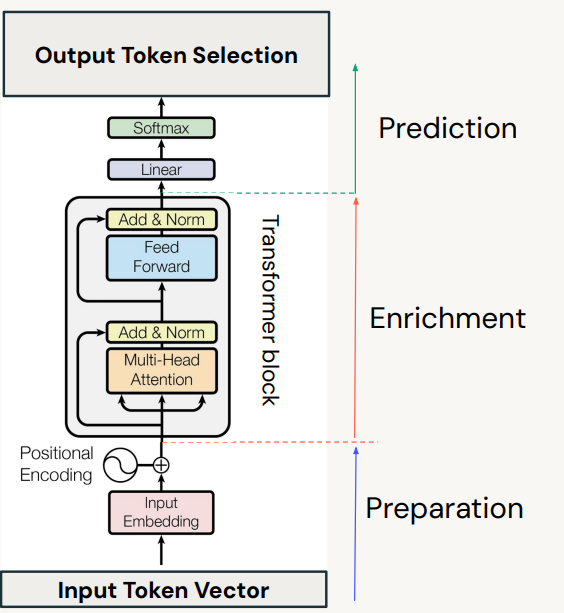

### First layer: Embedding

Embedding is basically a transformation function: given the set of tokens (input token) it maps each token/word (tokens are not necessarily words, it can be syllables but in our case we will use words as tokens, thus from now on token = word) to some vector of specified dimension
You might ask how is it different from encoding that we did above. The thing is that the numbers that we gave to each word does not hold any meaning. We just sorted our vocabulary and gave the number. That means that the numbers for man and for woman would be completely different. The neural network should understand that some words are closely related to each other like man and woman. Thus we use embedding. Each encoded word (number) will be then mapped to some vector. That is each word will be a vector in a high dimensional vector space. In this space neural network can understand how words are related to each other. For example, the similarity between men and women will be much higher than the similarity between men and cup. 

#### Example of an embedding layer

In [38]:
vocab_size = vocabulary
embedding_size = 2
embedding_layer = nn.Embedding(vocab_size, embedding_size) # (V, C)

In [39]:
input_token = encoded_data[:10]
print(decode(input_token))
# Convert into tensor
input_token = torch.tensor(input_token)
# Apply embedding
embedded_vector = embedding_layer(input_token)
print(embedded_vector)

 «Идиот».
Роман, в
tensor([[-0.3175,  0.3640],
        [-0.9877, -1.9036],
        [ 0.4776,  0.3135],
        [-0.3390,  0.3750],
        [ 0.3366,  0.8741],
        [-0.1046,  0.3364],
        [ 0.0944, -1.9118],
        [-0.2670, -2.3184],
        [ 0.2676, -1.1578],
        [-1.7623,  0.1452]], grad_fn=<EmbeddingBackward0>)


#### Positional encoding

Text why positional encoding is important and that we use simple arange 

In [40]:
pos_emb = nn.Embedding(10, embedding_size) # (T, C)

In [41]:
input_token = encoded_data[:10]
print(decode(input_token))
# Convert into tensor
input_token = torch.arange(10)
# Apply embedding
pos_embedded_vector = pos_emb(input_token)
print(pos_embedded_vector)

 «Идиот».
Роман, в
tensor([[-0.1908,  0.2349],
        [-0.0396, -0.2348],
        [-0.4781,  0.3728],
        [ 0.4204,  2.0819],
        [-1.1788, -0.5933],
        [-1.8450,  0.7556],
        [ 2.1773, -0.6320],
        [ 1.0585,  1.2245],
        [ 0.4109,  0.9374],
        [ 1.3532,  0.5776]], grad_fn=<EmbeddingBackward0>)


How to combine them? Easy

In [42]:
emb_vec = embedded_vector + pos_embedded_vector
print(emb_vec)

tensor([[-5.0829e-01,  5.9886e-01],
        [-1.0273e+00, -2.1384e+00],
        [-4.9829e-04,  6.8631e-01],
        [ 8.1355e-02,  2.4569e+00],
        [-8.4219e-01,  2.8080e-01],
        [-1.9497e+00,  1.0919e+00],
        [ 2.2717e+00, -2.5438e+00],
        [ 7.9143e-01, -1.0939e+00],
        [ 6.7850e-01, -2.2040e-01],
        [-4.0914e-01,  7.2281e-01]], grad_fn=<AddBackward0>)


In [43]:
class SimpleWriter(nn.Module):
    def __init__(self, vocab_size, n_embedding, context_length, device):
        super(SimpleWriter, self).__init__()

        self.emb_layer = nn.Embedding(vocab_size, n_embedding) # (V, C)
        self.pos_emb_layer = nn.Embedding(context_length, n_embedding) # (T, C)
        self.fc = nn.Linear(n_embedding, vocab_size) # (C, V)
        self.device = device
        
    def forward(self, x, y=None):
        # X имеет форму (B, T), Y имеет такую же форму
        B, T = x.shape
        
        emb_x = self.emb_layer(x) # на выходe форма (B,T,C)
        pos_emb_x = self.pos_emb_layer(torch.arange(T, device=self.device)) # (B, T, C)
        x = emb_x + pos_emb_x # # (B, T, C)
        logits = self.fc(x) # (B, T, V)
        B, T, V = logits.shape
        if y is not None:
            logits = logits.view(B*T, V) # (B*T, V)
            y = y.view(-1) # (B*T, 1)
            loss = F.cross_entropy(logits, y)
        else:
            loss = None
        return logits, loss

In [44]:
context_length = 16
n_embedding = 32
batch_size = 32
model = SimpleWriter(vocab_size, n_embedding=n_embedding, context_length=context_length, device=device).to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-3)

Попробуем понять помогает ли вообще pos_embedding

In [46]:
with tqdm(range(10000), desc="Training") as pbar:
    for e in pbar:
        x, y = get_batch(encoded_data, context_length=context_length, batch_size = batch_size)
        logits, loss = model.forward(x, y)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        if e % 100 == 0:
            losses = validate_loss(10, context_length=context_length, batch_size = batch_size)
            # Update the tqdm progress bar with the current loss
            pbar.set_postfix({"val_loss": losses[1].item()})
print(f"Final training loss: {losses[0].item()}")
print(f"Final validation loss: {losses[1].item()}")

Training: 100%|████████████| 10000/10000 [00:16<00:00, 620.10it/s, val_loss=6.2]

Final training loss: 5.533385276794434
Final validation loss: 6.196534156799316


In [47]:
def generate_text(x, max_words):
    for _ in range(max_words):
        if x.size(1) > context_length:
            logits, loss = model.forward(x[:, -context_length:]) # (B, V)
        else:
            logits, loss = model.forward(x) # (B, V)
        logits = logits[:,-1, :]
        probs = F.softmax(logits, dim=-1)
        next_word = torch.multinomial(probs, num_samples = 1)
        # Concatenate the next word to the input sequence
        x = torch.cat((x, next_word), dim=1)  # (B, T+1)
    return x
text = torch.tensor([encode("Я")], dtype=torch.long).view(1,1).to(device)
print(''.join(decode(generate_text(text, 100)[0].tolist())))

 Я они не боитесь, князь решаете, уже тебе все в такой основание сами продолжение рост назад характерицыье илиьяы повозиг ли они смумила и вдову четыре ломавать и вывст; а к Аглае теперь с ними. Живим он быстро с чрезвычайнымском виду, твердо смотреть, то быть, как фразный в своей пропалом человеком на утрепья да, они доселе и выпррлупая смешно, ждала такое? В контору. Сам ни, случилось ваш


Explain that this is a fluke. Because we only consider the last word, we do not really care about its position. Maybe it really helped, but the help is really small.

### Second Layer: Attention

#### Single-Head Attention

Explain that this layer (mechanism) is there only to relate different words in the context length with each other. We need to consider not only the last word as we did before, but we also need to consider the relations between words. 

##### Simplest solution: average

Самое простой механизм как соединить смысл всех слов в нашем примере это взять среднее значение наших преобразованных слов

In [48]:
embedding_size = 4
embedding_layer = nn.Embedding(vocab_size, embedding_size) # (V, C)
input_token = encoded_data[1000:1015]
print(decode(input_token))
# Convert into tensor
input_token = torch.tensor(input_token)
# Apply embedding
embedded_vector = embedding_layer(input_token)
print(embedded_vector)
print(embedded_vector.shape)

Зябко?
И повел плечами.
Очень,
tensor([[-7.1480e-01, -1.2398e+00, -2.0022e-02, -2.7500e-01],
        [-1.0587e+00, -3.8366e-01,  8.3696e-01, -1.0725e+00],
        [ 4.8563e-01,  3.6340e-02, -1.6133e+00,  1.9612e+00],
        [ 3.0706e-01, -1.8575e-01, -2.1147e-01, -1.1203e+00],
        [-1.2245e+00, -1.2428e-01, -2.5491e+00,  7.3054e-02],
        [-6.0685e-01,  5.0855e-01,  1.4477e+00,  7.0841e-01],
        [ 3.5813e-02,  2.3255e+00,  7.8169e-01,  1.7074e+00],
        [-6.0429e-02, -2.0208e-01,  3.2505e-01, -1.0140e-02],
        [ 7.8369e-01,  1.9045e+00, -8.2084e-01, -2.0449e-01],
        [ 1.2603e+00, -6.8902e-02,  2.0536e+00, -1.1356e+00],
        [-6.0685e-01,  5.0855e-01,  1.4477e+00,  7.0841e-01],
        [-2.5670e-01,  1.5643e+00,  1.0871e+00, -8.3382e-01],
        [-1.5678e+00, -9.6564e-02, -1.6030e-03, -5.8117e-01],
        [-4.1338e-02,  4.0241e-01,  4.1997e-01,  6.3345e-01],
        [-7.6024e-01,  7.9044e-01,  2.6154e-01, -1.1378e+00]],
       grad_fn=<EmbeddingBackward0>)
t

In [49]:
avg = torch.mean(embedded_vector, dim=0)
avg

tensor([-0.2684,  0.3826,  0.2297, -0.0386], grad_fn=<MeanBackward1>)

Мы превратили наше предложение в один вектор со всеми словами, но как мы помним из одного предложения мы получаем несколько примеров которые будут использоваться для тренировки модели. То есть нам нужно придумать схему по превращению ряда слов в один вектор со средним значением их векторов

In [50]:
vec_avg = torch.zeros(embedded_vector.shape)
import time 
start = time.time()
for i, w in enumerate(embedded_vector):
    vec_avg[i] = torch.mean(embedded_vector[:i+1], dim = 0)
loop_time = time.time() - start
print(f"Loop time: {loop_time:.5f}s")
vec_avg

Loop time: 0.00388s


tensor([[-0.7148, -1.2398, -0.0200, -0.2750],
        [-0.8868, -0.8117,  0.4085, -0.6738],
        [-0.4293, -0.5290, -0.2654,  0.2045],
        [-0.2452, -0.4432, -0.2519, -0.1267],
        [-0.4411, -0.3794, -0.7114, -0.0867],
        [-0.4687, -0.2314, -0.3515,  0.0458],
        [-0.3966,  0.1338, -0.1896,  0.2832],
        [-0.3546,  0.0919, -0.1253,  0.2465],
        [-0.2281,  0.2933, -0.2026,  0.1964],
        [-0.0793,  0.2570,  0.0230,  0.0632],
        [-0.1272,  0.2799,  0.1525,  0.1219],
        [-0.1380,  0.3869,  0.2304,  0.0422],
        [-0.2480,  0.3497,  0.2126, -0.0057],
        [-0.2332,  0.3535,  0.2274,  0.0399],
        [-0.2684,  0.3826,  0.2297, -0.0386]], grad_fn=<CopySlices>)

Циклы достаточно долгие, особенно если выполнять их каждую эпоху. Перемножение матриц намного быстрее и эфективнее, давай посмотрим как с помощью матриц мы можем сделать ту же самую операцию что и с циклом

In [51]:
a = torch.tensor([[1,1], [2,2] , [3, 3] , [4,4]]).float()
print(a)
b = torch.tril(torch.ones(4,4))
b = b / torch.sum(b, 1, keepdim=True)
print(b)
print(b@a)

tensor([[1., 1.],
        [2., 2.],
        [3., 3.],
        [4., 4.]])
tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500]])
tensor([[1.0000, 1.0000],
        [1.5000, 1.5000],
        [2.0000, 2.0000],
        [2.5000, 2.5000]])


In [52]:
avg_w = torch.tril(torch.ones(embedded_vector.shape[0], embedded_vector.shape[0]))
avg_w = avg_w / torch.sum(avg_w, 1, keepdim=True)
vec_avg = avg_w @ embedded_vector
print(vec_avg)

tensor([[-0.7148, -1.2398, -0.0200, -0.2750],
        [-0.8868, -0.8117,  0.4085, -0.6738],
        [-0.4293, -0.5290, -0.2654,  0.2045],
        [-0.2452, -0.4432, -0.2519, -0.1267],
        [-0.4411, -0.3794, -0.7114, -0.0867],
        [-0.4687, -0.2314, -0.3515,  0.0458],
        [-0.3966,  0.1338, -0.1896,  0.2832],
        [-0.3546,  0.0919, -0.1253,  0.2465],
        [-0.2281,  0.2933, -0.2026,  0.1964],
        [-0.0793,  0.2570,  0.0230,  0.0632],
        [-0.1272,  0.2799,  0.1525,  0.1219],
        [-0.1380,  0.3869,  0.2304,  0.0422],
        [-0.2480,  0.3497,  0.2126, -0.0057],
        [-0.2332,  0.3535,  0.2274,  0.0399],
        [-0.2684,  0.3826,  0.2297, -0.0386]], grad_fn=<MmBackward0>)


Давайте сравним, что быстрее и насколько

In [53]:
loop_time = []
matrix_time = []
cuda_time = []
context_length = 32
embedding_size = 64
embedding_layer = nn.Embedding(vocab_size, embedding_size) # (V, C)
avg_w = torch.tril(torch.ones(context_length, context_length))
avg_w = avg_w / torch.sum(avg_w, 1, keepdim=True)
avg_w_cuda = avg_w.to(device)
for i in range(100):
    ind = np.random.randint(len(encoded_data) - context_length)
    input_token = encoded_data[ind:ind+context_length]
    # Convert into tensor
    input_token = torch.tensor(input_token)
    embedded_vector = embedding_layer(input_token)
    vec_avg = torch.zeros(embedded_vector.shape)
    start = time.time()
    for j, w in enumerate(embedded_vector):
        vec_avg[j] = torch.mean(embedded_vector[:j+1], dim = 0)
    loop_time.append(time.time() - start)
    
    start = time.time()
    vec_avg = avg_w @ embedded_vector
    matrix_time.append(time.time() - start)
    
    embedded_vector = embedded_vector.to(device)
    start = time.time()
    vec_avg = avg_w_cuda @ embedded_vector
    cuda_time.append(time.time() - start)

In [54]:
loop_time = np.asarray(loop_time)
matrix_time = np.asarray(matrix_time)
cuda_time = np.asarray(cuda_time)

print(f"Среднее время используя циклы: {loop_time.mean()}s")
print(f"Среднее время используя матрицы: {matrix_time.mean()}s")
print(f"Среднее время используя CUDA: {cuda_time.mean()}s")

print(f"Матрицы быстрее циклов в ~{round(loop_time.mean() / matrix_time.mean())} раз")

Среднее время используя циклы: 0.0006934642791748047s
Среднее время используя матрицы: 4.021883010864258e-05s
Среднее время используя CUDA: 3.813028335571289e-05s
Матрицы быстрее циклов в ~17 раз


##### Давайте же посмотрим, получится ли с помощью простого среднего значения улучшить наш loss

In [55]:
class SimpleWriter(nn.Module):
    def __init__(self, vocab_size, n_embedding, context_length, device):
        super(SimpleWriter, self).__init__()
        self.context_length = context_length
        self.avg_w = torch.tril(torch.ones(context_length, context_length))
        self.avg_w = self.avg_w / torch.sum(self.avg_w, 1, keepdim=True)
        self.avg_w = self.avg_w.to(device)
        self.emb_layer = nn.Embedding(vocab_size, n_embedding) # (V, C)
        self.pos_emb_layer = nn.Embedding(context_length, n_embedding) # (T, C)
        self.fc = nn.Linear(n_embedding, vocab_size) # (C, V)
        self.device = device
        
    def forward(self, x, y=None):
        # X имеет форму (B, T), Y имеет такую же форму
        B, T = x.shape
        if T <= self.avg_w.size(0):
            # If input length is less than or equal to context_length, use a slice of avg_w
            avg_w = self.avg_w[:T, :T]
        else:
            # If input length is greater than context_length, create a new averaging matrix
            avg_w = torch.tril(torch.ones(T, T, device=self.device))
            avg_w = avg_w / torch.sum(avg_w, 1, keepdim=True)
        emb_x = self.emb_layer(x) # на выходe форма (B,T,C)
        pos_emb_x = self.pos_emb_layer(torch.arange(T, device=self.device)) # (B, T, C)
        x = emb_x + pos_emb_x # # (B, T, C)
        emb_x = avg_w @ emb_x
        logits = self.fc(x) # (B, T, V)
        B, T, V = logits.shape
        if y is not None:
            logits = logits.view(B*T, V) # (B*T, V)
            y = y.view(-1) # (B*T, 1)
            loss = F.cross_entropy(logits, y)
        else:
            loss = None
        return logits, loss

In [56]:
context_length = 8
n_embedding = 32
batch_size = 32
model = SimpleWriter(vocab_size, n_embedding=n_embedding, context_length=context_length, device=device).to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-3)
with tqdm(range(10000), desc="Training") as pbar:
    for e in pbar:
        x, y = get_batch(encoded_data, context_length=context_length, batch_size = batch_size)
        logits, loss = model.forward(x, y)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        if e % 100 == 0:
            losses = validate_loss(10, context_length=context_length, batch_size = batch_size)
            # Update the tqdm progress bar with the current loss
            pbar.set_postfix({"val_loss": losses[1].item()})
print(f"Final training loss: {losses[0].item()}")
print(f"Final validation loss: {losses[1].item()}")

Training: 100%|███████████| 10000/10000 [00:16<00:00, 614.56it/s, val_loss=6.52]


Final training loss: 5.797731876373291
Final validation loss: 6.515690803527832


In [57]:
text = torch.tensor([encode("Я")], dtype=torch.long).view(1,1).to(device)
print(''.join(decode(generate_text(text, 100)[0].tolist())))

 Я меня давку.
Как таким господинке! Я тебя падил волнения укусали, потом пакетым неделю ему нос. Была вывитель видите, буду на уверены теперь вдруг ничего говорил Алеша, распространалась, почти прежде он в нем, встретились любви.
Да, чтоб я хочу даже вижу идвиг h проговорил
Это ячь Иван шелциюи к невинные эта понравил? Да не верьте, заключне с серьезным Катерина Ивановна радостно сидеть.
О, прохма великение Раскольникова


Честно, среднее значение всех слов ухудшило наши результаты, так что использовать среднее значение не вариант. Если подумать, то это и логично, раньше модель смотрела на последнее слово, и пыталась угадать какое слово должно идти после него. Сейчас же мы из ряда слов делаем какое-то одно слово, непонятное и нам и модели

Как же нам связать слова между собой, чтобы наша модель могла понять концептуальную связь между словами? Ответ: внимание (attention)

Внимание очень интересный блок в трансформерах и я не могу его лучше объяснить чем сделали это здесь, прошу посмотреть видео, понять что делает блок и как он это делает, потом вернуться сюда и попробовать написать его самому: https://www.youtube.com/watch?v=eMlx5fFNoYc

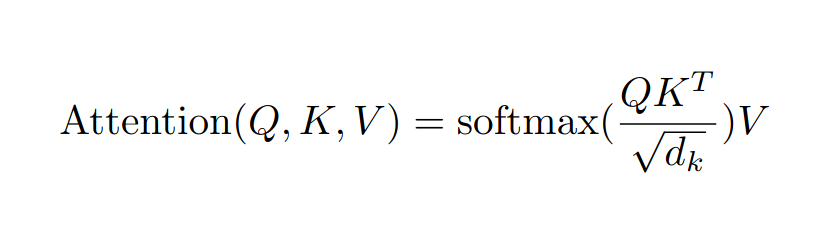

In [58]:
class SingleHeadAttention(nn.Module):
    def __init__(self, embedding_dim, attention_dim):
        super(SingleHeadAttention, self).__init__()
        self.k = nn.Linear(embedding_dim, attention_dim, bias=False)
        self.q = nn.Linear(embedding_dim, attention_dim, bias=False)
        self.v = nn.Linear(embedding_dim, attention_dim, bias=False)
        self.attention_dim = attention_dim
    def forward(self, x):
        # x это наш ряд слов уже встроенный в вектор
        # размер х - (размер батча B, размер ряда слов T, размер embedding С
        k = self.k(x) # (B, T, A) A - размер блока внимания
        q = self.q(x) # (B, T, A)
        v = self.v(x) # (B, T, A)
        scores = q @ torch.transpose(k, 1, 2) / (self.attention_dim ** 0.5)
        triangle = torch.tril(torch.ones(x.shape[1], x.shape[1], device=x.device))
        mask = triangle == 0
        scores = scores.masked_fill(mask, float('-inf'))
        scores = nn.functional.softmax(scores, dim = 2)
        return scores @ v

In [59]:
class SimpleWriter(nn.Module):
    def __init__(self, vocab_size, n_embedding, context_length, device):
        super(SimpleWriter, self).__init__()
        self.context_length = context_length
        self.emb_layer = nn.Embedding(vocab_size, n_embedding) # (V, C)
        self.pos_emb_layer = nn.Embedding(context_length, n_embedding) # (T, C)
        self.fc = nn.Linear(n_embedding, vocab_size) # (C, V)
        self.attention = SingleHeadAttention(n_embedding, n_embedding)
        self.device = device
        self.to(device)
    def forward(self, x, y=None):
        # X имеет форму (B, T), Y имеет такую же форму
        B, T = x.shape
        
        emb_x = self.emb_layer(x) # на выходe форма (B,T,C)
        pos_emb_x = self.pos_emb_layer(torch.arange(T, device=self.device)) # (B, T, C)
        x = emb_x + pos_emb_x # # (B, T, C)
        x = self.attention(x)
        logits = self.fc(x) # (B, T, V)
        B, T, V = logits.shape
        if y is not None:
            logits = logits.view(B*T, V) # (B*T, V)
            y = y.view(-1) # (B*T, 1)
            loss = F.cross_entropy(logits, y)
        else:
            loss = None
        return logits, loss

In [60]:
context_length = 8
n_embedding = 32
batch_size = 32
model = SimpleWriter(vocab_size, n_embedding=n_embedding, context_length=context_length, device=device)
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-3)
with tqdm(range(10000), desc="Training") as pbar:
    for e in pbar:
        x, y = get_batch(encoded_data, context_length=context_length, batch_size = batch_size)
        logits, loss = model.forward(x, y)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        if e % 100 == 0:
            losses = validate_loss(10, context_length=context_length, batch_size = batch_size)
            # Update the tqdm progress bar with the current loss
            pbar.set_postfix({"val_loss": losses[1].item()})
print(f"Final training loss: {losses[0].item()}")
print(f"Final validation loss: {losses[1].item()}")

Training: 100%|███████████| 10000/10000 [00:20<00:00, 491.11it/s, val_loss=6.44]

Final training loss: 5.81032657623291
Final validation loss: 6.443750858306885


In [61]:
text = torch.tensor([encode("Я")], dtype=torch.long).view(1,1).to(device)
print(''.join(decode(generate_text(text, 100)[0].tolist())))

 Я только ни одногомите не все, ход.
Надоточки. Князь этих нагло, он у нас водобрал его жест, убиваются на попавар с, но ведь это он чувствовал, что исчез молодого обвиницался из непрляло, помолчал, что недавно; не могли на полу, пред собою уверяю буду какой-то много сидлоп, это сам и проч у насами, вот, тенел улицу, не может быть. Чий Ставрогин! согласен. При повореннаяра


In [63]:
class SingleHeadAttention(nn.Module):
    def __init__(self, embedding_dim, context_length, head_size, dropout):
        super(SingleHeadAttention, self).__init__()
        self.k = nn.Linear(embedding_dim, head_size, bias=False)
        self.q = nn.Linear(embedding_dim, head_size, bias=False)
        self.v = nn.Linear(embedding_dim, head_size, bias=False)
        self.dropout = nn.Dropout(dropout)     
        self.register_buffer('tril', torch.tril(torch.ones(context_length, context_length)))

    def forward(self, x):
        # x это наш ряд слов уже встроенный в вектор
        # размер х - (размер батча B, размер ряда слов T, размер embedding С
        k = self.k(x) # (B, T, A) A - размер блока внимания (head_size)
        q = self.q(x) # (B, T, A)
        v = self.v(x) # (B, T, A)
        scores = q @ torch.transpose(k, -2, -1) * k.shape[-1]**-0.5
        scores = scores.masked_fill(self.tril[:k.shape[1], :k.shape[1]] == 0, float('-inf'))
        scores = F.softmax(scores, dim = -1)
        scores = self.dropout(scores)
        return scores @ v

class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim, context_length, num_heads, head_size, dropout):
        super().__init__()
        self.heads = nn.ModuleList([SingleHeadAttention(embedding_dim, context_length, head_size, dropout) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, embedding_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):
    def __init__(self, embedding_dim, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embedding_dim, 4 * embedding_dim),
            nn.ReLU(),
            nn.Linear(4 * embedding_dim, embedding_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):

    def __init__(self, embedding_dim, context_length, num_heads, dropout):
        # embedding_dim: embedding dimension, num_heads: the number of heads we'd like
        super().__init__()
        head_size = embedding_dim // num_heads
        self.sa = MultiHeadAttention(embedding_dim, context_length, num_heads, head_size, dropout)
        self.ffwd = FeedForward(embedding_dim, dropout)
        self.ln1 = nn.LayerNorm(embedding_dim)
        self.ln2 = nn.LayerNorm(embedding_dim)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPT(nn.Module):

    def __init__(self, vocab_size, context_length, embedding_dim, num_heads, num_layers, dropout):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim)
        self.position_embedding_layer = nn.Embedding(context_length, embedding_dim)
        
        self.blocks = nn.Sequential(*[Block(embedding_dim, context_length, num_heads, dropout) for _ in range(num_layers)])
        self.ln_f = nn.LayerNorm(embedding_dim) # final layer norm
        self.lm_head = nn.Linear(embedding_dim, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, x, targets=None):
        B, T = x.shape

        # x and targets are both (B,T) tensor of integers
        tok_emb = self.embedding_layer(x) # (B,T,C)
        pos_emb = self.position_embedding_layer(torch.arange(T, device=x.device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

def generate_text(model, x, max_words, context_length):
    model.eval()
    with torch.no_grad():
        for _ in range(max_words):
            if x.size(1) > context_length:
                logits, loss = model.forward(x[:, -context_length:]) # (B, V)
            else:
                logits, loss = model.forward(x) # (B, V)
            logits = logits[:,-1, :]
            probs = F.softmax(logits, dim=-1)
            next_word = torch.multinomial(probs, num_samples = 1)
            # Concatenate the next word to the input sequence
            x = torch.cat((x, next_word), dim=1)  # (B, T+1)
    model.train()
    return x

def validate_loss(n, context_length, batch_size):
    out = {}
    model.eval()
    with torch.no_grad():
        train_losses = torch.zeros(n)
        val_losses = torch.zeros(n)
        for k in range(n):
            x, y = get_batch(encoded_data, context_length, batch_size)
            logits, loss = model.forward(x, y)
            train_losses[k] = loss.item()
            
            x, y = get_batch(encoded_val_data, context_length, batch_size)
            logits, loss = model.forward(x, y)
            val_losses[k] = loss.item()
            
    model.train()
    return train_losses.mean(), val_losses.mean()

In [64]:
batch_size = 64
context_length = 256
embedding_dim = 16
num_heads = 8
num_layers = 8
dropout = 0.2
eval_period = 1000
eval_iter = 20
model = GPT(vocab_size=vocab_size, context_length = context_length, 
            embedding_dim = embedding_dim, num_heads = num_heads, 
            num_layers = num_layers, dropout=dropout).to(device)
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

0.359984 M parameters


In [65]:
best_val_loss = float('inf')
patience = 10
no_improve = 0
# model.load_state_dict(torch.load('best_model.pth'))
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor = 0.5, patience=3)
val_losses = []
with tqdm(range(100000), desc="Training") as pbar:
    for e in pbar:
        x, y = get_batch(encoded_data, context_length=context_length, batch_size = batch_size)
        logits, loss = model.forward(x, y)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        if e % eval_period == 0:
            losses = validate_loss(eval_iter, context_length=context_length, batch_size = batch_size)
            # Update the tqdm progress bar with the current loss
            pbar.set_postfix({"val_loss": losses[1].item()})
            val_loss = losses[1].item()
            val_losses.append(val_loss)
            scheduler.step(val_loss)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                no_improve = 0
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                no_improve += 1
                if no_improve >= patience:
                    print(f"Early stopping at epoch {e}")
                    break

print(f"Final training loss: {losses[0].item()}")
print(f"Final validation loss: {losses[1].item()}")
print(f"Best validation loss: {best_val_loss}")

Training: 100%|████████| 100000/100000 [4:08:08<00:00,  6.72it/s, val_loss=5.91]

Final training loss: 5.476614952087402
Final validation loss: 5.907269477844238
Best validation loss: 5.89942741394043


In [70]:
text = torch.tensor([encode("Россия")], dtype=torch.long).view(1,1).to(device)
print(''.join(decode(generate_text(model, text, 500, 64)[0].tolist())))

 Россия карты никогда у неправ сорок лет нанула с каждым воскресенье противливая низость, действительно и извин есть Евгительного, точно подвигы», и довольно земли, бесконечно своей удивлениемная, как еще скорыми, около, закричие ста комнаты как разним в моем шляпу, положения, и с какой-селаськами и уже был колен! Тут несмотря на комнату в любви песеня, и раздадить в бреду, и целые шагах, и врагами и нельзя! И теперь, это рряду, доволь Антонович не понимая. Он попросил с него, дескать, когда он, некоторые теряя Варвара Петровна в эту мыслей никогда, рад, то, разумеется. «пил Петр Степанович, что проговорить песельенного необыкновенному забнусинке, на свете, глядел в которые это, с содом разгорячляться, картыции отец же вечер был пальто и сем Сделайте бы не пускали свой роковое пред нею, на счастия! Иилось и оттах и дурен черезнием того, ты последние@ с болью не бывцы или, то этот припадках, чтоб у пор съаженном для знаками бывали осмелилось Разумихин, при многих разлиной, напротив, тол